In [1]:
# Import Libraries
import pandas as pd
import geopandas
import folium
# import folium.plugins as plugins
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# used functions

def plot_setores_in_map(gdf, map):
    """Given a GeoDataFrame with a column named 'GEOMETRIA' and rows that represent Setores, add the polygons to map

    Parameters
    ----------
    gdf : GeoDataFrame
        _description_
    map : folium.Map
        _description_
    """
    for _, r in gdf.iterrows():
        geo_j = folium.GeoJson(data=r['GEOMETRIA'], style_function=lambda x: {"color": 'black', "weight": 1,"fillColor": 'grey', "fillOpacity": 0.4})
        geo_j.add_to(map)


def plot_markers_in_map(map, geometria_fichas, inside_icon='home'):
    """ Adicionar no mapa os pontos definidos na coluna latlong de geometria_fichas com um marcador que contem o simbolo inside_icon

    Parameters
    ----------
    map : _type_
        _description_
    geometria_fichas : _type_
        _description_
    inside_icon : str, optional
        _description_, by default 'home'
    """

    for _, r in geometria_fichas.iterrows():
        
        cor=r['COR']
        home_icon = f'<i class="fa fa-{inside_icon}" aria-hidden="true" style="position:absolute; color:white; font-size:7pt; padding:0; margin:0;top:3px;left:3px"></i>'
        marker_icon = f'<i class="fa fa-map-marker" style="position:relative; font-size:17pt; color:{cor};">{home_icon}</i>'
        outline_icon = '<i class="fa fa-map-marker" style="position:relative; font-size:19pt; color:black;"></i>'
        # pin_icon = f'<i class="fa fa-map-pin"  style="position:relative; font-size:17pt; color:{cor};"></i>'
        
        # icon = plugins.BeautifyIcon(prefix='fa', icon="home", icon_shape="marker", background_color=cor, border=1, border_color='black')
        divicon = folium.DivIcon(icon_anchor=(7,22), html=f'<div style="background-color: transparent; ">{marker_icon}</div>')
        my_marker = folium.Marker(icon=divicon)
        
        geo_j = folium.GeoJson(data=r['latlong'], marker=my_marker)
        geo_j2 = folium.GeoJson(data=r['latlong'], marker=folium.Marker(icon=folium.DivIcon(icon_anchor=(8,23), html=f'<div style="background-color: transparent; ">{outline_icon}</div>')))
        # folium.Marker(location=[r['GPS_LAT_FICHA'], r['GPS_LONG_FICHA']], icon=icon).add_to(my_map2)
        # folium.Marker(location=[r['GPS_LAT_FICHA'], r['GPS_LONG_FICHA']], icon=divicon).add_to(my_map2)
        
        geo_j2.add_to(map)
        geo_j.add_to(map)

def create_latlong_col(df, lat_col='GPS_LAT_FICHA', long_col='GPS_LONG_FICHA'):
    
    list_latlong = []
    for _, r in df.iterrows():
        list_latlong.append(Point(r[long_col], r[lat_col]))
    df['latlong'] = list_latlong
    
def map_markers_in_sections(setores_gdf, geometria_fichas, tag='moradias', save=False, save_path=''):
    
    my_map2 = folium.Map(location=[setores_gdf["centroid"].y.mean(), setores_gdf["centroid"].x.mean()], tiles="cartodb positron")
    # define zoom
    sw = geometria_fichas[['GPS_LAT_FICHA','GPS_LONG_FICHA']].min().values.tolist()
    ne = geometria_fichas[['GPS_LAT_FICHA','GPS_LONG_FICHA']].max().values.tolist()
    my_map2.fit_bounds([sw, ne])

    plot_setores_in_map(setores_gdf, my_map2)
    plot_markers_in_map(my_map2, geometria_fichas)
    
    if save:
        my_map2.save(f'{save_path}mapa_{tag}.html')
        
    return my_map2

In [3]:
#paths
tables_path = "../data/apex_tables/"
images_path = "/Users/anabottura/PycharmProjects/FDTE/auto_relatorios/data/html_outputs/images/"


In [4]:
# import tables from apex
ficha = pd.read_excel(f"{tables_path}ficha.xlsx")
area_cadastro = pd.read_excel(f"{tables_path}area_cadastro-2.xlsx")
df1 = pd.read_excel(f"{tables_path}mapa_areas_hidro_geo-2.xlsx")

/Users/anabottura/PycharmProjects/FDTE/auto_relatorios/env/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/anabottura/PycharmProjects/FDTE/auto_relatorios/env/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/anabottura/PycharmProjects/FDTE/auto_relatorios/env/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [5]:
# filter interesting columns
# TODO: Do the same to the other tables
df = df1.loc[:, ("ID_MAPA", "RHD_NOME", "RHD_SIGLA", "RHD_SETOR", "RHD_GRAU", "GEOMETRIA", "CENTRO_LAT", "CENTRO_LONG", "COR")]

In [6]:
a_risco = 'CAMARAZAL'

In [7]:
# transform geoJSON (in "GEOMETRIA") into a Polygon from geopandas

area_df = df[df['RHD_NOME']==a_risco]
area_df = area_df.reset_index(drop=True)
gdf = geopandas.GeoDataFrame()
for i, g in enumerate(area_df['GEOMETRIA']):
    row = geopandas.read_file(g, driver='GeoJson')
    gdf = pd.concat([gdf, row])

gdf = gdf.reset_index(drop=True)
area_df['geometry']=gdf

/var/folders/71/y3v1hnr56p3dphvpd_z7lnbm0000gn/T/ipykernel_50392/2170157878.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_gdf["centroid"] = new_gdf.centroid.to_crs(epsg=4326)


-46.75055363502116

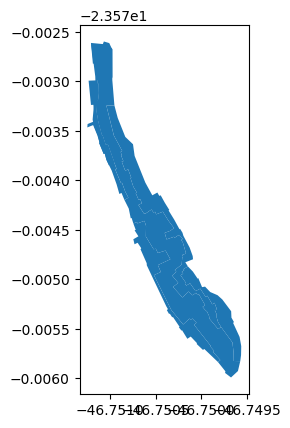

In [8]:
new_gdf = geopandas.GeoDataFrame(area_df)
new_gdf.plot()
new_gdf["centroid"] = new_gdf.centroid.to_crs(epsg=4326)
new_gdf["centroid"].y.mean()
new_gdf["centroid"].x.mean()

In [9]:
# Generate map with colored sectors and labels

my_map = folium.Map(location=[new_gdf["centroid"].y.mean(), new_gdf["centroid"].x.mean()], tiles="cartodb positron")

# set zoom acording to boundaries
bounds = new_gdf['geometry'].total_bounds
my_map.fit_bounds([[bounds[1],bounds[0]],[bounds[3], bounds[2]]])

num_points=1000 # used to find best placement of label
for _, r in new_gdf.iterrows():
    
    cor=r['COR']
    geo_j = folium.GeoJson(data=r['GEOMETRIA'], style_function=lambda x, fillColor=cor: {"color": 'black', "fillColor": fillColor, "fillOpacity": 1})
    
    
    random_points = [Point(np.random.uniform(r['geometry'].bounds[0], r['geometry'].bounds[2]), np.random.uniform(r['geometry'].bounds[1], r['geometry'].bounds[3]))
                     for _ in range(num_points)]
    inside_points = [point for point in random_points if r['geometry'].contains(point)]
    
    if inside_points:
        max_distance_point = max(inside_points, key=lambda p: r['geometry'].boundary.distance(p))
        folium.Marker(location = [max_distance_point.y, max_distance_point.x], icon=folium.DivIcon(icon_size=(5,5), icon_anchor=(10,10),html=f'<div style="font-size:10pt; font-color:black; font-weight:bold">{r["RHD_GRAU"]}</div>')).add_to(geo_j)
    geo_j.add_to(my_map)

my_map.save(f'{images_path}mapa_setores.html')

In [10]:
# join data to get forms from specific area and colors associated with sectors

dados_fichas_areas = ficha.merge(area_cadastro,left_on='ID_AREA_FICHA', right_on='ID_CAD_AREA') # juntar dados das areas associadas as fichas
geometria_fichas = dados_fichas_areas.merge(new_gdf, left_on='SETOR', right_on='RHD_SETOR')

In [11]:
create_latlong_col(geometria_fichas, lat_col = 'GPS_LAT_FICHA', long_col = 'GPS_LONG_FICHA')
map_markers_in_sections(new_gdf, geometria_fichas, tag='moradias', save=True, save_path=images_path)

In [13]:
import asyncio
import pathlib
from pyppeteer import launch
import nest_asyncio
nest_asyncio.apply()

def html_to_png(html_file, png_file):
    async def generate_pdf(url, png_path):
        browser = await launch({'defaultViewport': {'width':1440,'height':900}})
        page = await browser.newPage()
        
        await page.goto(url)
        await page.screenshot({'path': png_path, 'width':2880, 'height':1800})
        
        await browser.close()

    # Run the function
    
    url_path = pathlib.Path(html_file).as_uri()
    asyncio.get_event_loop().run_until_complete(generate_pdf(url_path, png_file))

name_tag = 'mapa_setores'
map_file=f'{images_path}{name_tag}.html'
output_png = f'{images_path}{name_tag}.png'
html_to_png(map_file, output_png)



In [ ]:
# my_map2 = folium.Map(location=[new_gdf["centroid"].y.mean(), new_gdf["centroid"].x.mean()], tiles="cartodb positron")

# # define zoom
# sw = geometria_fichas[['GPS_LAT_FICHA','GPS_LONG_FICHA']].min().values.tolist()
# ne = geometria_fichas[['GPS_LAT_FICHA','GPS_LONG_FICHA']].max().values.tolist()
# my_map2.fit_bounds([sw, ne])


# for _, r in new_gdf.iterrows():
#     geo_j = folium.GeoJson(data=r['GEOMETRIA'], style_function=lambda x: {"color": 'black', "weight": 1,"fillColor": 'grey', "fillOpacity": 0.4})
#     geo_j.add_to(my_map2)


# for _, r in geometria_fichas.iterrows():
    
#     cor=r['COR']
#     home_icon = '<i class="fa fa-home" aria-hidden="true" style="position:absolute; color:white; font-size:7pt; padding:0; margin:0;top:3px;left:3px"></i>'
#     marker_icon = f'<i class="fa fa-map-marker" style="position:relative; font-size:17pt; color:{cor};">{home_icon}</i>'
#     outline_icon = '<i class="fa fa-map-marker" style="position:relative; font-size:19pt; color:black;"></i>'
#     pin_icon = f'<i class="fa fa-map-pin"  style="position:relative; font-size:17pt; color:{cor};"></i>'
    
#     # icon = plugins.BeautifyIcon(prefix='fa', icon="home", icon_shape="marker", background_color=cor, border=1, border_color='black')
#     divicon = folium.DivIcon(icon_anchor=(7,22), html=f'<div style="background-color: transparent; ">{marker_icon}</div>')
    
#     my_marker = folium.Marker(icon=divicon)
#     geo_j = folium.GeoJson(data=r['latlong'], marker=my_marker)
#     geo_j2 = folium.GeoJson(data=r['latlong'], marker=folium.Marker(icon=folium.DivIcon(icon_anchor=(8,23), html=f'<div style="background-color: transparent; ">{outline_icon}</div>')))
#     # folium.Marker(location=[r['GPS_LAT_FICHA'], r['GPS_LONG_FICHA']], icon=icon).add_to(my_map2)
#     # folium.Marker(location=[r['GPS_LAT_FICHA'], r['GPS_LONG_FICHA']], icon=divicon).add_to(my_map2)
    
#     geo_j2.add_to(my_map2)
#     geo_j.add_to(my_map2)
    
